# DOG & CAT Detection

In [1]:
#plt.style.use('ggplot')
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("./cat-and-dog-4000/"))

['.DS_Store', 'test_set.zip', 'training_set', 'training_set.zip', 'test_set']


In [3]:
!pip install tqdm

     |████████████████████████████████| 51kB 366kB/s eta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from random import randint
from sklearn.utils import shuffle
from tqdm import tqdm #Progress Bars
from PIL import Image

In [5]:
train_path = "./cat-and-dog-4000/training_set/"
test_path = "./cat-and-dog-4000/test_set/"

img_height = 200
img_width = 200
img_size = 200

### Crop images

In [6]:
def resize_image(image):
    height, width = image.shape
    cropped = image
    if height < width:
        diff = (width - height) // 2
        cropped = image[:, diff: (diff + height)]
    elif height > width:
        diff = (height - width) // 2
        cropped = image[diff: (diff + width), :]

    height, width = cropped.shape
    if height > img_size:    # shrink image
        return cv2.resize(cropped, (img_size, img_size), interpolation=cv2.INTER_AREA)
    elif height < img_size:  # enlarge image
        return cv2.resize(cropped, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    else:
        return cropped

### Load images

In [7]:
def get_images(train_path):
    Images = []
    Labels = []  # 0 for Building , 1 dog, 2 for cat
    Filenames = []
    label = 0
        
    for labels in os.listdir(train_path): #Main Directory where each class label is present as folder name.
        if "DS_Store" in labels:
            continue
        if labels == 'cats': #Folder contain Cat Images get the '0' class label.
            label = 0
            count = 0;
        elif labels == 'dogs':
            label = 1
            count = 0;
        
        for image_file in tqdm(os.listdir(train_path + labels)): #Extracting the file name of the image from Class Label folder
            if ".jpg" not in image_file:
                continue
            count += 1;
            path = train_path + labels +r'/' + image_file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #Reading the image (OpenCV)
            image = resize_image(image) #Resizing is very Important
            if count <= 3000:
                Images.append(image)
                Labels.append(label)
                Filenames.append(path)
    
    return shuffle(Images, Labels, Filenames, random_state=817328462) #Shuffle the dataset you just prepared.


### Train set and labels

In [8]:
train_images, train_labels, train_filenames = get_images('./cat-and-dog-4000/training_set/') #Extract the training images from the folders.

x_train = np.asarray(train_images) #converting the list of images to numpy array.
y_train = np.asarray(train_labels)

100%|██████████| 4001/4001 [00:39<00:00, 102.47it/s]


In [9]:
x_train = x_train/255.0
x_train.shape

(6000, 200, 200)

In [10]:
y_train = y_train.reshape(x_train.shape[0], 1)
y_train.shape

(6000, 1)

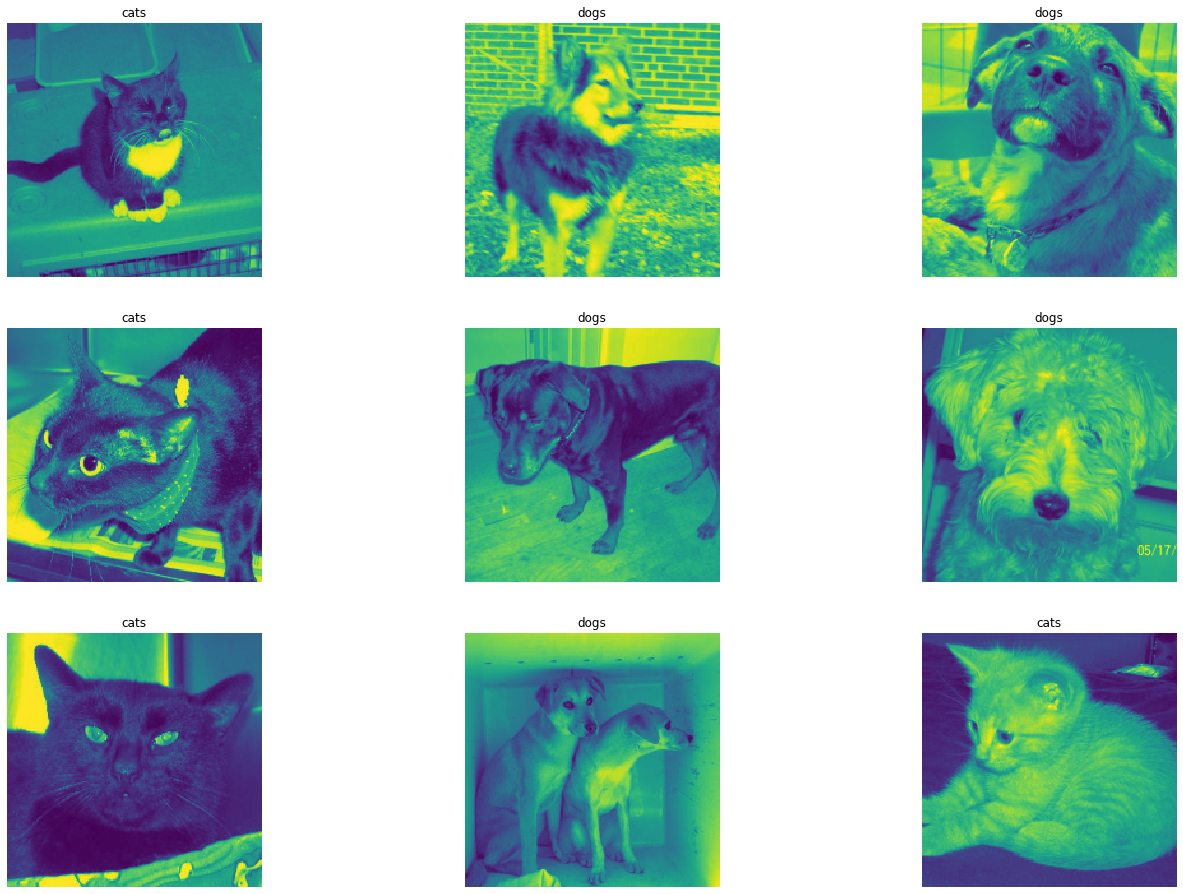

In [11]:
def get_classlabel(class_code):
    labels = {0:'cats', 1:'dogs'}
    
    return labels[class_code]

f, ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0, len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]))
        ax[i,j].axis('off')

In [12]:
number_of_train = x_train.shape[0]

In [13]:
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1]*x_train.shape[2])

print("X train flatten", x_train_flatten.shape)

X train flatten (6000, 40000)


In [14]:
#transpose
x_train = x_train_flatten.T #Same as self.transpose(), except that self is returned if self.ndim < 2
y_train = y_train.T

print("x train: ", x_train.shape)
print("y train: ", y_train.shape)

x train:  (40000, 6000)
y train:  (1, 6000)


## TRAIN WITH LOGISTIC REGRESSION

In [15]:
def init_weights_and_bias(dimension):
    weight = np.full((dimension, 1), 0.01)
    bias = 0.0
    return weight, bias

In [16]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z)) #1/(1+e^-x)
    return y_head

In [17]:
def forward_backward_propagation(weight, bias, x_train, y_train):
    # forward propagation
    z = np.dot(weight.T, x_train) + bias
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head) #-(y^)*log(ŷhat)-(1-y)*log(1-ŷhat)
    cost = (np.sum(loss))/x_train.shape[1] #x_train.shape[1]  is for scaling
    
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost, gradients

In [18]:
def update_weight(weight, bias, x_train, y_train, learning_rate, number_of_iterarion, is_train):
    cost_list = []
    cost_list_plt = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost, gradients = forward_backward_propagation(weight, bias, x_train, y_train)
        cost_list.append(cost)
        
        weight = weight - learning_rate * gradients["derivative_weight"]
        bias = bias - learning_rate * gradients["derivative_bias"]
        
        if is_train and i > 0 and i % 2000 == 0:
            cost_list_plt.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %.4f" %(i, cost))
                
    parameters = {"weight": weight, "bias": bias}
    
    if is_train:
        plt.plot(index, cost_list_plt)
        plt.xticks(index, rotation='vertical')
        plt.xlabel("Number of Iterarion")
        plt.ylabel("Cost")
        plt.show()
        
    return parameters, gradients, cost_list

In [19]:
def predict(weight, bias, x_test):
    
    z = sigmoid(np.dot(weight.T, x_test) + bias)
    Y_prediction = np.zeros((1, x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0, i] <= 0.5:
            Y_prediction[0, i] = 0 #Cat
        else:
            Y_prediction[0, i] = 1 #Dog

    return Y_prediction

In [20]:
def logistic_regression(x_train, y_train, learning_rate, num_iterations, is_train):

    dimension =  x_train.shape[0]
    weight, bias = init_weights_and_bias(dimension)

    parameters, gradients, cost_list = update_weight(weight, bias, x_train, y_train, learning_rate, num_iterations, is_train)
    
    y_prediction_train = predict(parameters["weight"], parameters["bias"], x_train)
    
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100, 2)))
    
    return y_prediction_train

Cost after iteration 2000: 0.7379
Cost after iteration 4000: 0.7014
Cost after iteration 6000: 0.6725
Cost after iteration 8000: 0.6478


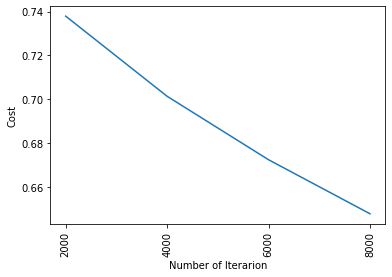

Train Accuracy: 62.97 %


In [21]:
train_result = logistic_regression(x_train, y_train, learning_rate=0.001, num_iterations=10000, is_train=True)

In [22]:
np.save('train_result_001_10k.npy', train_result)

In [23]:
train_result

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
train_result = np.load('train_result_001_10k.npy')

## Test with another data

In [26]:
test_images, test_labels, test_filenames = get_images('./cat-and-dog-4000/test_set/')

100%|██████████| 1012/1012 [00:11<00:00, 91.59it/s] 


In [27]:
x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)

In [28]:
x_test = x_test/255.0

In [29]:
y_test = y_test.reshape(x_test.shape[0], 1)

In [30]:
number_test = x_test.shape[0]
x_flatten_test = x_test.reshape(number_test, x_test.shape[1]*x_test.shape[2])

x_test = x_flatten_test.T
y_test = y_test.T

In [31]:
def test_logistic_regression(x_test, y_test, learning_rate, num_iterations, is_train):

    dimension =  x_train.shape[0]
    weight, bias = init_weights_and_bias(dimension)

    parameters, gradients, cost_list = update_weight(weight, bias, x_test, y_test, learning_rate, num_iterations, is_train)
    
    y_prediction_test = predict(parameters["weight"], parameters["bias"], x_test)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100, 2)))
    
    return y_prediction_test

In [32]:
test_result = test_logistic_regression(x_test, y_test, learning_rate=0.0009, num_iterations=20000, is_train=False)

Test Accuracy: 89.27 %


In [28]:
number_show = 50

df_filenames = test_filenames[:number_show]
df_labels = test_labels[:number_show]
df_result = test_result[0][:number_show]

data_frame = pd.DataFrame({
    'filename': df_filenames,
    'label': df_labels,
    'predict': df_result
})

data_frame

filename  label  predict
0   input/test_set/dogs/dog.4627.jpg      1      1.0
1   input/test_set/cats/cat.4186.jpg      0      0.0
2   input/test_set/dogs/dog.4899.jpg      1      1.0
3   input/test_set/cats/cat.4284.jpg      0      0.0
4   input/test_set/dogs/dog.4542.jpg      1      1.0
5   input/test_set/dogs/dog.4764.jpg      1      1.0
6   input/test_set/cats/cat.4371.jpg      0      0.0
7   input/test_set/dogs/dog.4437.jpg      1      1.0
8   input/test_set/cats/cat.4947.jpg      0      0.0
9   input/test_set/cats/cat.4851.jpg      0      0.0
10  input/test_set/cats/cat.4812.jpg      0      0.0
11  input/test_set/cats/cat.4603.jpg      0      0.0
12  input/test_set/dogs/dog.4991.jpg      1      1.0
13  input/test_set/cats/cat.4310.jpg      0      0.0
14  input/test_set/cats/cat.4754.jpg      0      0.0
15  input/test_set/dogs/dog.4588.jpg      1      1.0
16  input/test_set/cats/cat.4558.jpg      0      1.0
17  input/test_set/dogs/dog.4424.jpg      1      1.0
18  input/test_set/cats/cat.4904.jpg      0      0.0
19  input/test_set/cats/cat.4136.jpg      0      0.0
20  input/test_set/cats/cat.4237.jpg      0      0.0
21  input/test_set/dogs/dog.4870.jpg      1      0.0
22  input/test_set/dogs/dog.4102.jpg      1      1.0
23  input/test_set/dogs/dog.4616.jpg      1      1.0
24  input/test_set/dogs/dog.4380.jpg      1      1.0
25  input/test_set/cats/cat.4643.jpg      0      0.0
26  input/test_set/dogs/dog.4857.jpg      1      1.0
27  input/test_set/dogs/dog.4910.jpg      1      1.0
28  input/test_set/dogs/dog.4730.jpg      1      0.0
29  input/test_set/cats/cat.4285.jpg      0      0.0
30  input/test_set/cats/cat.4886.jpg      0      0.0
31  input/test_set/cats/cat.4343.jpg      0      0.0
32  input/test_set/dogs/dog.4943.jpg      1      1.0
33  input/test_set/cats/cat.4249.jpg      0      0.0
34  input/test_set/dogs/dog.4995.jpg      1      1.0
35  input/test_set/dogs/dog.4481.jpg      1      1.0
36  input/test_set/dogs/dog.4960.jpg      1      1.0
37  input/test_set/dogs/dog.4848.jpg      1      1.0
38  input/test_set/dogs/dog.4449.jpg      1      1.0
39  input/test_set/dogs/dog.4818.jpg      1      1.0
40  input/test_set/cats/cat.4129.jpg      0      0.0
41  input/test_set/dogs/dog.4071.jpg      1      1.0
42  input/test_set/cats/cat.4207.jpg      0      0.0
43  input/test_set/dogs/dog.4916.jpg      1      1.0
44  input/test_set/dogs/dog.4596.jpg      1      0.0
45  input/test_set/cats/cat.4393.jpg      0      0.0
46  input/test_set/cats/cat.4349.jpg      0      0.0
47  input/test_set/dogs/dog.4445.jpg      1      1.0
48  input/test_set/dogs/dog.4456.jpg      1      1.0
49  input/test_set/cats/cat.4874.jpg      0      0.0

In [29]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

#dictionary to name the prediction
predict_target = {0: 'CAT', 1: 'DOG'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    
def display_HTML(filename, prediction):
    target = 'DOG'        
    if prediction <= 0.5:
        target = 'CAT'
            
    html = '''
        <div style="overflow: auto;  border: 2px solid #D8D8D8;
            padding: 5px; width: 420px;" >
            <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
            <div style="padding: 10px 0px 0px 20px; overflow: auto;">
                <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
                <p style="margin-left: 50px; margin-top: 0px; font-size: 12px">Filename: {}</p>
            </div>
        </div>
        '''.format(img_to_display(filename), target, filename.split('/')[-1])

    display(HTML(html))

input/test_set/dogs/dog.4627.jpg



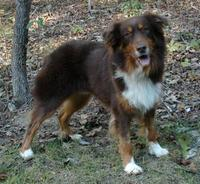

input/test_set/cats/cat.4186.jpg



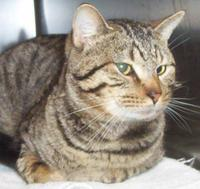

input/test_set/dogs/dog.4899.jpg



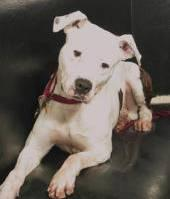

input/test_set/cats/cat.4284.jpg



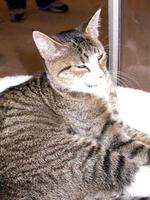

input/test_set/dogs/dog.4542.jpg



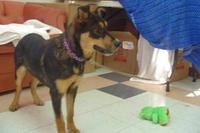

input/test_set/dogs/dog.4764.jpg



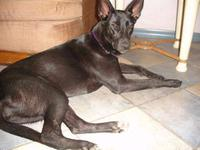

input/test_set/cats/cat.4371.jpg



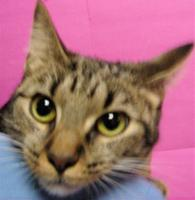

input/test_set/dogs/dog.4437.jpg



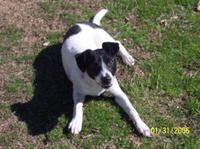

input/test_set/cats/cat.4947.jpg



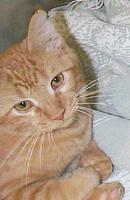

input/test_set/cats/cat.4851.jpg



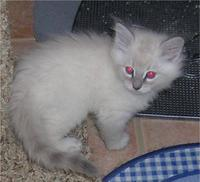

input/test_set/cats/cat.4812.jpg



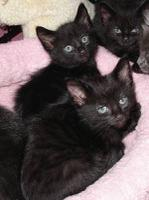

input/test_set/cats/cat.4603.jpg



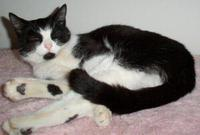

input/test_set/dogs/dog.4991.jpg



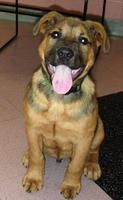

input/test_set/cats/cat.4310.jpg



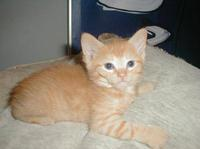

input/test_set/cats/cat.4754.jpg



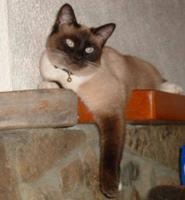

input/test_set/dogs/dog.4588.jpg



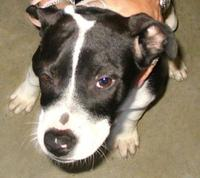

input/test_set/cats/cat.4558.jpg



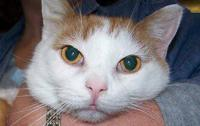

input/test_set/dogs/dog.4424.jpg



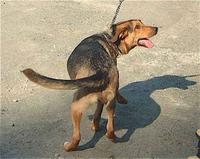

input/test_set/cats/cat.4904.jpg



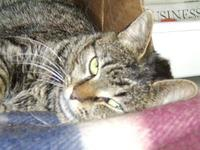

input/test_set/cats/cat.4136.jpg



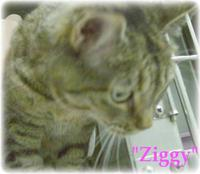

input/test_set/cats/cat.4237.jpg



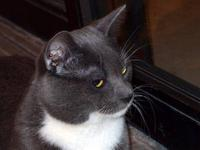

input/test_set/dogs/dog.4870.jpg



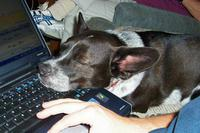

input/test_set/dogs/dog.4102.jpg



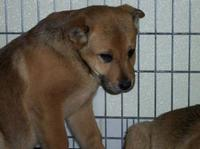

input/test_set/dogs/dog.4616.jpg



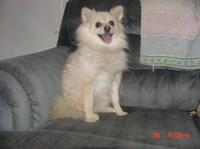

input/test_set/dogs/dog.4380.jpg



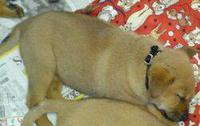

input/test_set/cats/cat.4643.jpg



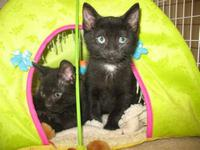

input/test_set/dogs/dog.4857.jpg



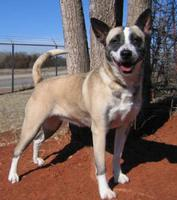

input/test_set/dogs/dog.4910.jpg



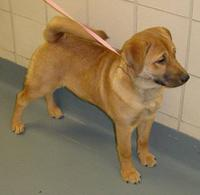

input/test_set/dogs/dog.4730.jpg



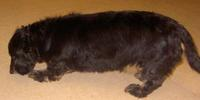

input/test_set/cats/cat.4285.jpg



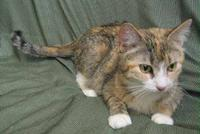

input/test_set/cats/cat.4886.jpg



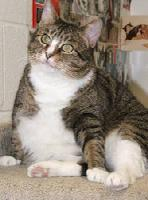

input/test_set/cats/cat.4343.jpg



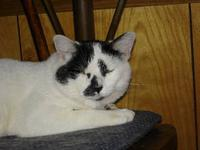

input/test_set/dogs/dog.4943.jpg



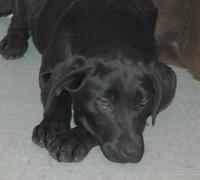

input/test_set/cats/cat.4249.jpg



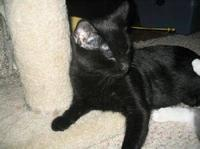

input/test_set/dogs/dog.4995.jpg



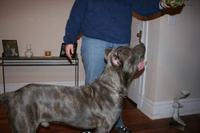

input/test_set/dogs/dog.4481.jpg



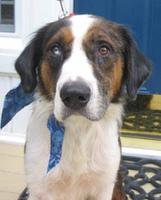

input/test_set/dogs/dog.4960.jpg



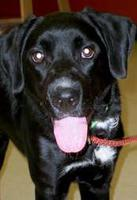

input/test_set/dogs/dog.4848.jpg



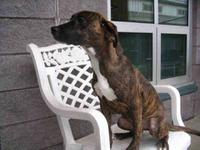

input/test_set/dogs/dog.4449.jpg



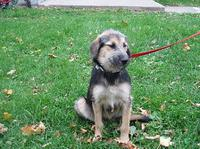

input/test_set/dogs/dog.4818.jpg



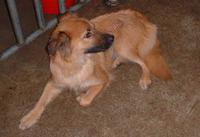

input/test_set/cats/cat.4129.jpg



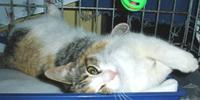

input/test_set/dogs/dog.4071.jpg



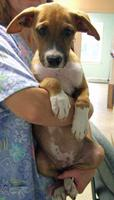

input/test_set/cats/cat.4207.jpg



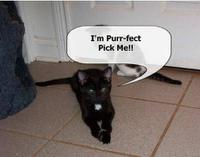

input/test_set/dogs/dog.4916.jpg



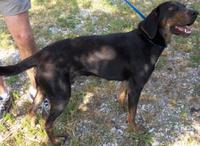

input/test_set/dogs/dog.4596.jpg



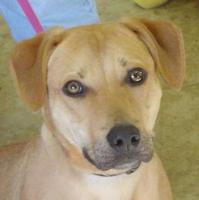

input/test_set/cats/cat.4393.jpg



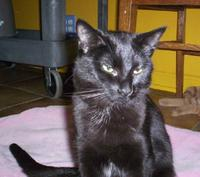

input/test_set/cats/cat.4349.jpg



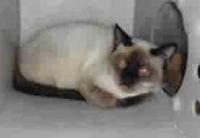

input/test_set/dogs/dog.4445.jpg



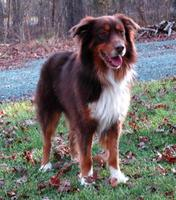

input/test_set/dogs/dog.4456.jpg



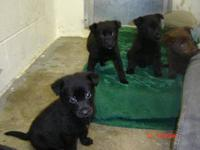

input/test_set/cats/cat.4874.jpg



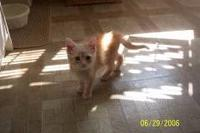

In [30]:
for index, row in data_frame.iterrows():
    print(row['filename'])
    display_HTML(row['filename'], row['predict'])